# Implementación de Difusión Anisotrópica con Python

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

from skimage import io, color


DATA_DIR = "./images"
def load_image(img_name):
    fn = os.path.join(DATA_DIR, img_name)
    img = io.imread(fn)
    img = color.rgb2gray(img)
    return img

imagen_1 = load_image("image1.jpg")
imagen_2 = load_image("image2.jpg")
imagen_3 = load_image("image3.jpg")
imagen_4 = load_image("image4.jpg")

# Funciones de difusión
> Más adelante se explica a detalle la aplicación de la difusión anisotrópica, esta requiere de la implementación de las funciones de difusión, que retorna un $c(x, y, t)$, tal que

- **Tipo 1:** $g(|x|) = e^{(\frac{-|x|^2}{K^2} )}$

- **Tipo 2:** $g(|x|) = \frac{1}{1 + \frac{|x|^2}{K^2}}$

- **Tipo 3** $g(|x|) = \frac{1}{\sqrt{1 + \frac{|x|^2}{K^2}}}$


In [3]:
def g_tipo1(grado_magnitud, K):
    if K == 0:
        return np.where(grado_magnitud == 0, 1.0, 0.0)
    return np.exp(-(grado_magnitud**2) / (K**2))

def g_tipo2(grado_magnitud, K):
    if K == 0:
        return np.where(grado_magnitud == 0, 1.0, 0.0)
    return 1.0 / (1.0 + (np.abs(grado_magnitud)**2) / (K**2))

def g_tipo3(grado_magnitud, K):
    if K == 0:
        return np.where(grado_magnitud == 0, 1.0, 0.0)
    return 1.0 / np.sqrt(1.0 + (np.abs(grado_magnitud)**2) / (K**2))

# Difusión Anisotrópica
> La idea de difusión anisotrópica es la distribución desigual de la "cantidad" de difusión en la imagen respecto de la dirección.

**Parámetros**:
- image (numpy.ndarray): Input de imagen en escala de grises.
- n_iter (int): Número de iteraciones.
- K (float): Coeficiente de "conducción" de calor, también conocido cómo kappa.
- delta_t (float): Constante de integración "time step".
- option (int): 1, 2, o 3 para elegir las implementaciones previas para $g(|x|)$.

**Retorna**:
- numpy.ndarray: La imágen difusa.

In [4]:
def difusion_anisotropica(image, n_iter, K, delta_t, option):
    # Checkear si esta en escala de grises
    if image.ndim != 2:
        raise ValueError("La imagen debe de estar en escala de grises.")

    imagen_difusa = image.copy()

    # Elegir funcion de difusion
    if option == 1:
        g_func = g_tipo1
    elif option == 2:
        g_func = g_tipo2
    elif option == 3:
        g_func = g_tipo3
    else:
        raise ValueError("Se debe de elegir una opcion valida (1, 2 o 3).")

    # Para cada iteracion, calculamos los gradientes y actualizamos la imagen
    for _ in range(n_iter):
        # Calculamos los gradientes en las direcciones N, S, E, W
        grad_N = imagen_difusa[:-2, 1:-1] - imagen_difusa[1:-1, 1:-1]
        grad_S = imagen_difusa[2:, 1:-1]  - imagen_difusa[1:-1, 1:-1]
        grad_E = imagen_difusa[1:-1, 2:]  - imagen_difusa[1:-1, 1:-1]
        grad_W = imagen_difusa[1:-1, :-2] - imagen_difusa[1:-1, 1:-1]

        # Calculamos las magnitudes de los gradientes
        cN = g_func(grad_N, K)
        cS = g_func(grad_S, K)
        cE = g_func(grad_E, K)
        cW = g_func(grad_W, K)

        # Actualizamos la imagen difusa
        # Evitamos los bordes para no salirnos de los límites de la imagen
        imagen_difusa[1:-1, 1:-1] += delta_t * (
            cN * grad_N +
            cS * grad_S +
            cE * grad_E +
            cW * grad_W
        )
    return imagen_difusa

## Mostrar imágenes
> Para evitar la repetición de código, se encapsula la función usando los métodos de `matplotlib` con el fin de mostrar el resultado de la difusión para cada una de las funciones de difusión previamente mostradas.

In [5]:
def mostrar_imagen(imagen_ruidosa, titulo, iteraciones, kappa, delta_t):
    # Se aplica la difusion anisotropica para cada una de las 3 funciones de difusion
    img_diffused_type1 = difusion_anisotropica(imagen_ruidosa.copy(), iteraciones, kappa, delta_t, option=1)
    img_diffused_type2 = difusion_anisotropica(imagen_ruidosa.copy(), iteraciones, kappa, delta_t, option=2)
    img_diffused_type3 = difusion_anisotropica(imagen_ruidosa.copy(), iteraciones, kappa, delta_t, option=3)

    # Mostrar las imagenes
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    ax = axes.ravel()

    # Imagen original
    ax[0].imshow(imagen_ruidosa, cmap='gray')
    ax[0].set_title(titulo)
    ax[0].axis('off')

    # Imagen con funcion de tipo 1
    ax[1].imshow(img_diffused_type1, cmap='gray')
    ax[1].set_title(f"Tipo 1: exp(-|x|^2/K^2)\nK={kappa}")
    ax[1].axis('off')

    # Imagen con funcion de tipo 2
    ax[2].imshow(img_diffused_type2, cmap='gray')
    ax[2].set_title(f"Tipo 2: 1/(1+(|x|^2/K))\nK={kappa}")
    ax[2].axis('off')

    # Imagen con funcion de tipo 3
    ax[3].imshow(img_diffused_type3, cmap='gray')
    ax[3].set_title(f"Tipo 3: 1/sqrt(1+(|x|^2/K))\nK={kappa}")
    ax[3].axis('off')

    # Mostrar todo
    plt.tight_layout()
    plt.show()

# Imagen 1
> Para acentuar una de las capacidades principales de los filtros de difusión, se añaden ruidos de distinto tipo a las imágenes propuestas (Gaussiano, Sal y Pimienta, Speckle).

**Se dejan acá los parámetros a controlar para facilidad de uso.**

In [6]:
iteraciones_test = 40
kappa_test = 0.09
delta_t_test = 0.15

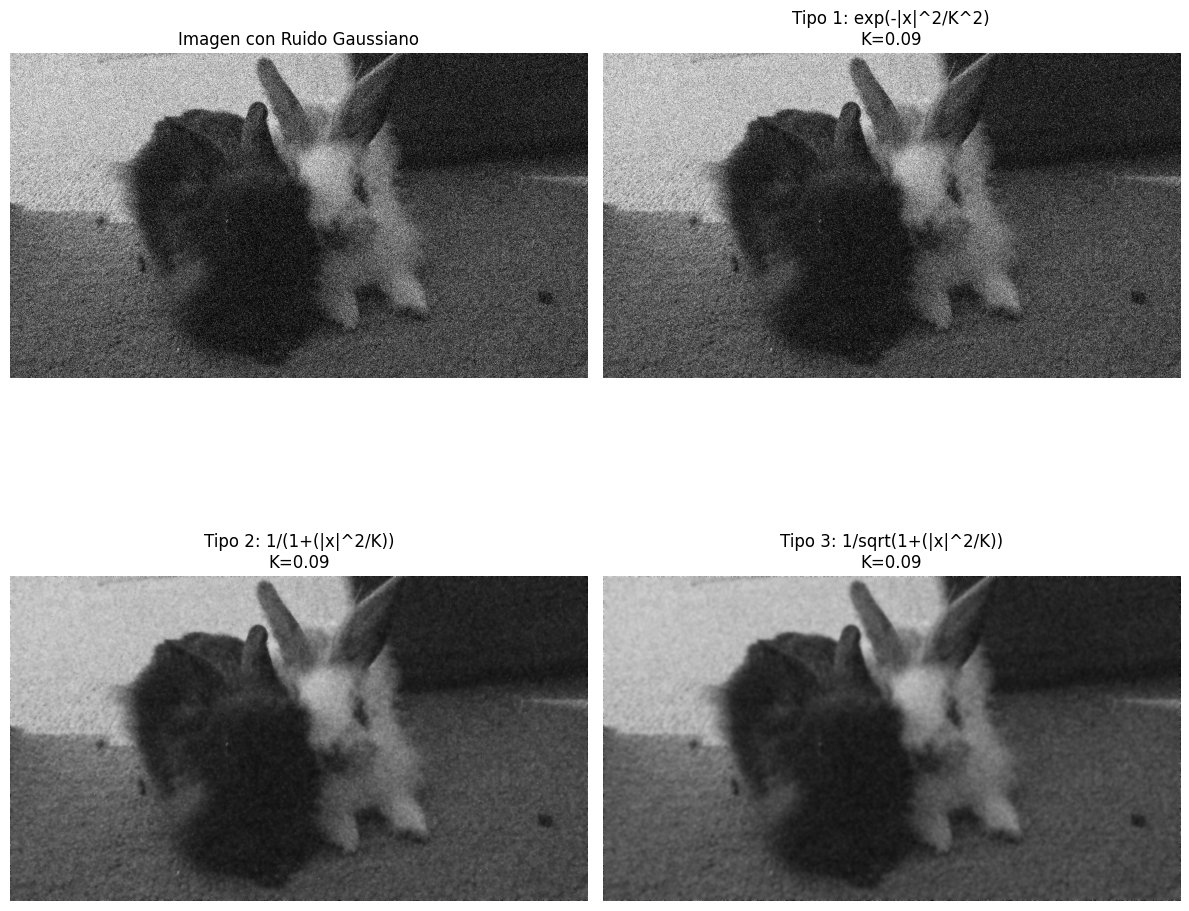

In [7]:
imagen_ruidosa_1 = skimage.util.random_noise(imagen_1, mode='gaussian', var=0.05)
mostrar_imagen(imagen_ruidosa_1, titulo="Imagen con Ruido Gaussiano", iteraciones=iteraciones_test, kappa=kappa_test, delta_t=delta_t_test)

# Imagen 2

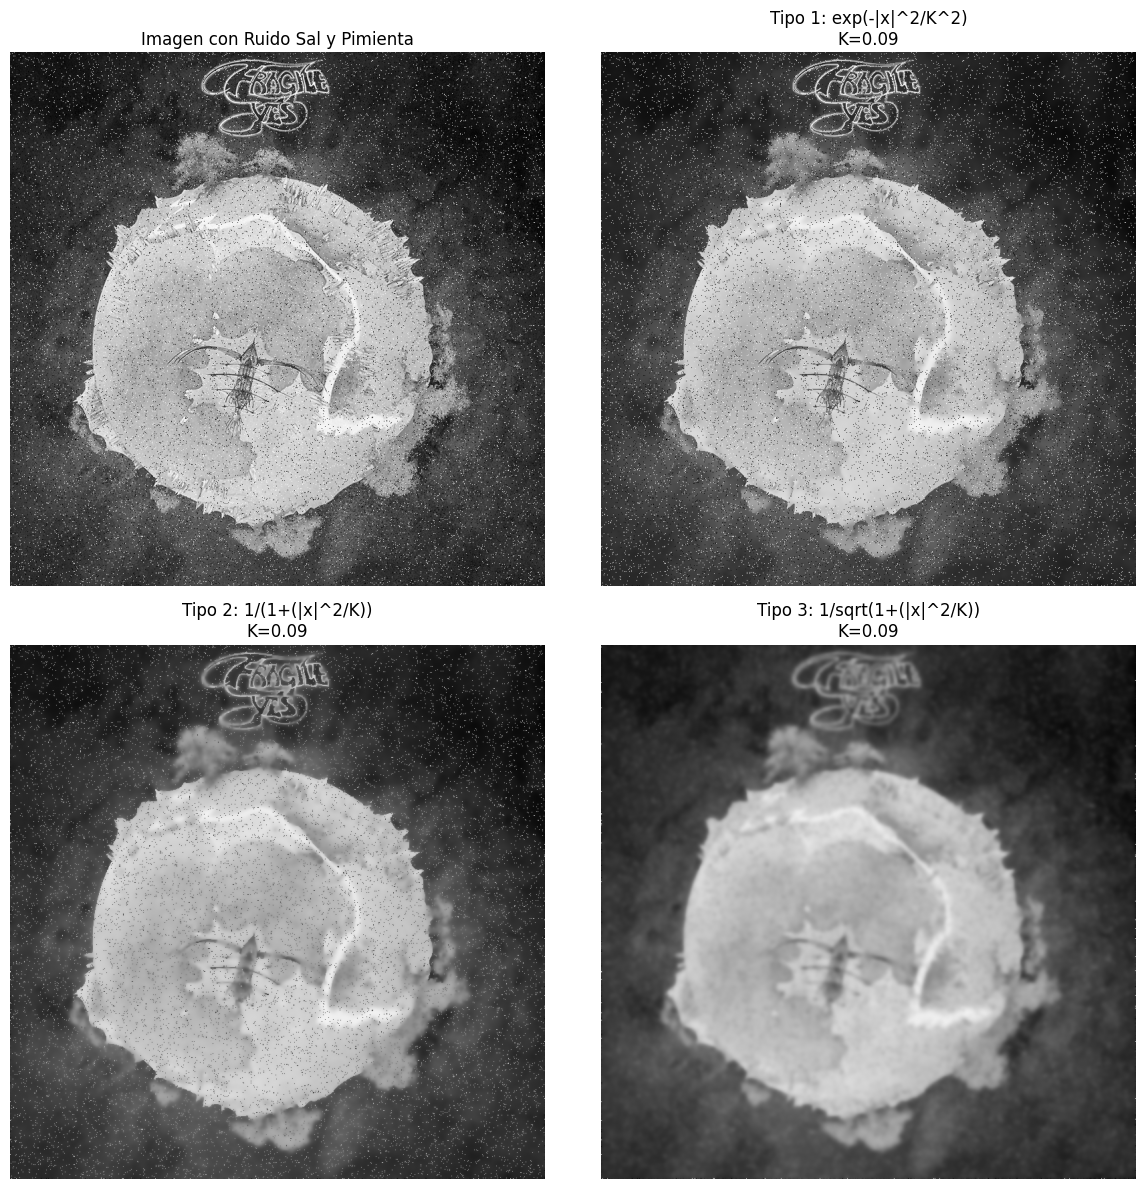

In [8]:
imagen_ruidosa_2 = skimage.util.random_noise(imagen_2, mode="s&p", amount=0.05)
mostrar_imagen(imagen_ruidosa_2, titulo="Imagen con Ruido Sal y Pimienta", iteraciones=iteraciones_test, kappa=kappa_test, delta_t=delta_t_test)

# Imagen 3

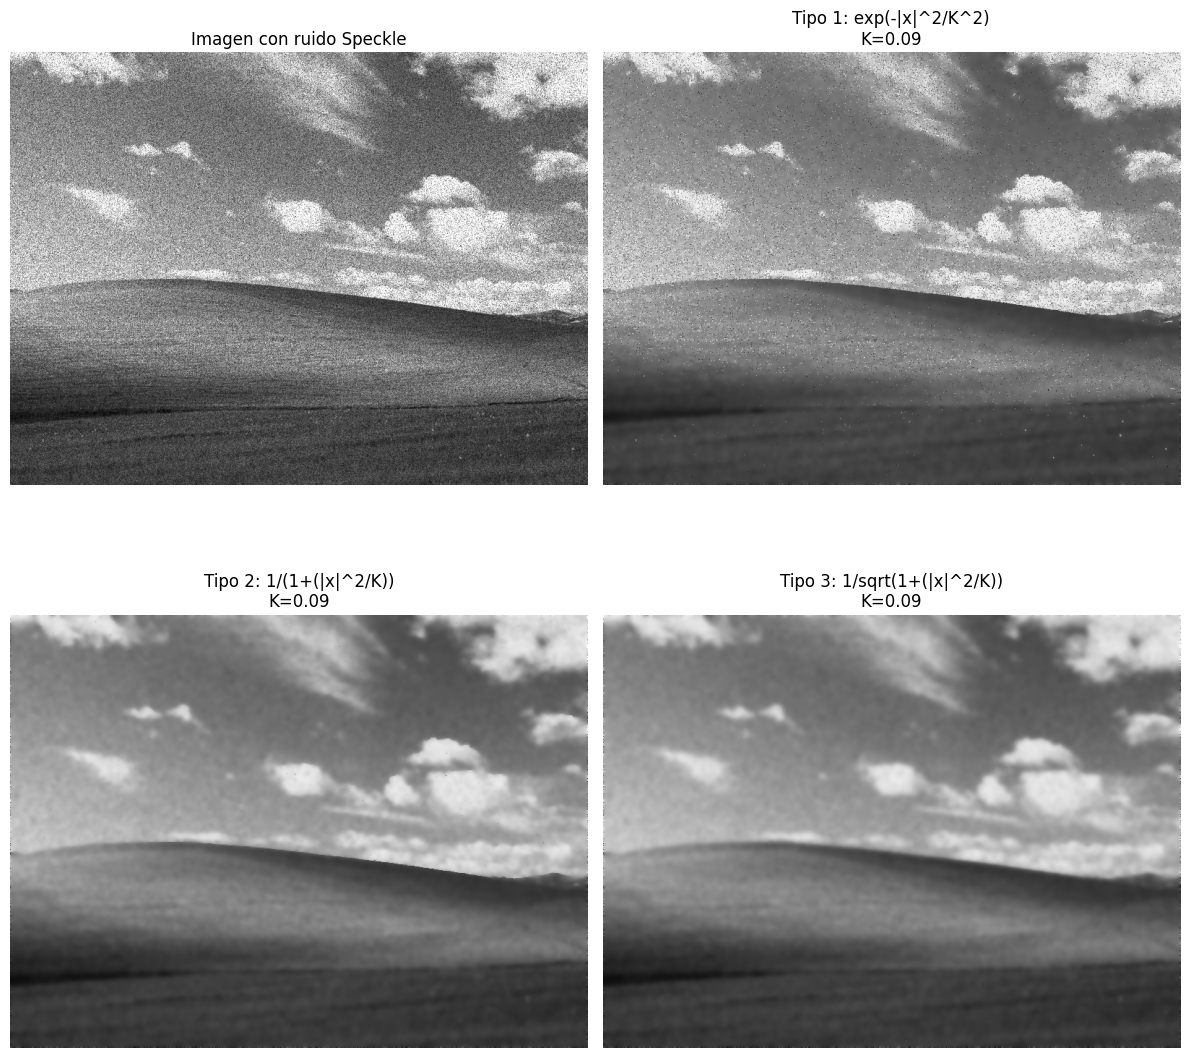

In [9]:
imagen_ruidosa_3 = skimage.util.random_noise(imagen_3, mode='speckle', var=0.05)
mostrar_imagen(imagen_ruidosa_3, titulo="Imagen con ruido Speckle",  iteraciones=iteraciones_test, kappa=kappa_test, delta_t=delta_t_test)

# Imagen 4

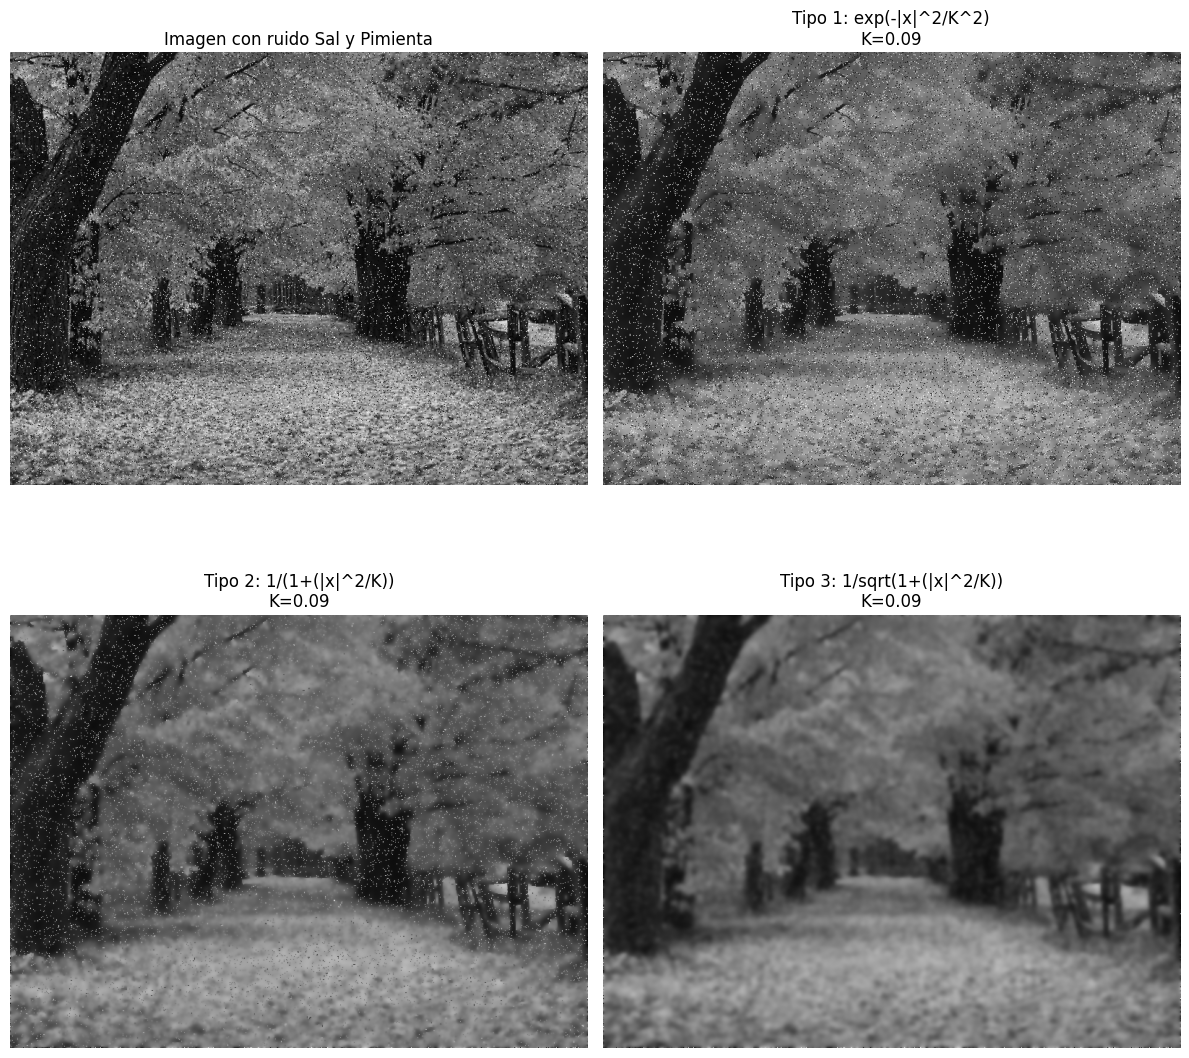

In [10]:
imagen_ruidosa_4 = skimage.util.random_noise(imagen_4, mode="s&p", amount=0.07)
mostrar_imagen(imagen_ruidosa_4, titulo="Imagen con ruido Sal y Pimienta",  iteraciones=iteraciones_test, kappa=kappa_test, delta_t=delta_t_test)